In [1]:
%load_ext autoreload
%autoreload 2
import os
import numpy as np
import pickle
import warnings
warnings.filterwarnings("ignore")
import matplotlib
matplotlib.use('Qt5Agg')
import matplotlib.pyplot as plt
from matplotlib import gridspec
plt.ion()
import pandas as pd
from datetime import datetime
from coastsat import SDS_download, SDS_preprocess, SDS_shoreline, SDS_tools, SDS_transects,SDS_islands,SDS_universal_transects

In [2]:
# region of interest (longitude, latitude in WGS84), can be loaded from a .kml polygon
polygon = SDS_tools.polygon_from_kml(os.path.join(os.getcwd(), 'example','veyofushi_finolhu.kml'))
# date range
dates = ['2016-01-01', '2024-01-01']
# satellite missions
sat_list = ['S2']
# choose Landsat collection 'C01' or 'C02'
collection = 'C02'
# name of the site
sitename = 'veyofushi_finolhu'
# directory where the data will be stored
filepath = os.path.join(os.getcwd(), 'data')
# put all the inputs into a dictionnary

inputs = {'polygon': polygon, 'dates': dates, 'sat_list': sat_list, 'sitename': sitename, 'filepath':filepath,
         'landsat_collection': collection}

# before downloading the images, check how many images are available for your inputs
SDS_download.check_images_available(inputs);

Number of images available between 2016-01-01 and 2024-01-01:
- In Landsat Tier 1 & Sentinel-2 Level-1C:
     S2: 443 images
  Total to download: 443 images


The function `SDS_download.retrieve_images(inputs)` retrives the satellite images from Google Earth Engine.

By default, only Landsat Tier 1 and Sentinel-2 Level-1C are downloaded. 

In case you need to access Tier 2 images for qualitative analysis, you need to set `inputs['include_T2'] = True` before calling `retrieve_images`.

In [3]:
# # inputs['include_T2'] = True
# metadata = SDS_download.retrieve_images(inputs)

Number of images available between 2016-01-01 and 2024-01-01:
- In Landsat Tier 1 & Sentinel-2 Level-1C:
     S2: 443 images
  Total to download: 443 images

S2: 443 images
100%
Satellite images downloaded from GEE and save in d:\Github\CoastSat\data\veyofushi_finolhu


In [4]:
#create a function that recursively searches a folder for filenames that include the string "dup" and deletes them
def remove_duplicates(folder):
    for root, dirs, files in os.walk(folder):
        for file in files:
            if "dup" in file:
                os.remove(os.path.join(root, file))
                print(f"removed {file}")


In [5]:
#remove_duplicates('data/veyofushi_finolhu')

removed 2016-01-03-05-39-16_S2_veyofushi_finolhu_mask_dup1.tif
removed 2016-01-23-05-39-10_S2_veyofushi_finolhu_mask_dup1.tif
removed 2016-02-02-05-37-03_S2_veyofushi_finolhu_mask_dup1.tif
removed 2016-02-12-05-37-02_S2_veyofushi_finolhu_mask_dup1.tif
removed 2016-03-03-05-37-01_S2_veyofushi_finolhu_mask_dup1.tif
removed 2016-03-23-05-32-16_S2_veyofushi_finolhu_mask_dup1.tif
removed 2016-04-12-05-37-15_S2_veyofushi_finolhu_mask_dup1.tif
removed 2016-04-22-05-37-18_S2_veyofushi_finolhu_mask_dup1.tif
removed 2016-05-02-05-37-20_S2_veyofushi_finolhu_mask_dup1.tif
removed 2016-05-22-05-37-22_S2_veyofushi_finolhu_mask_dup1.tif
removed 2016-06-11-05-37-19_S2_veyofushi_finolhu_mask_dup1.tif
removed 2016-07-01-05-37-18_S2_veyofushi_finolhu_mask_dup1.tif
removed 2016-07-11-05-37-19_S2_veyofushi_finolhu_mask_dup1.tif
removed 2016-07-21-05-37-20_S2_veyofushi_finolhu_mask_dup1.tif
removed 2016-07-31-05-37-20_S2_veyofushi_finolhu_mask_dup1.tif
removed 2016-08-10-05-37-19_S2_veyofushi_finolhu_mask_d

**If you have already retrieved the images**, just load the metadata file by only running the section below

In [6]:
metadata = SDS_download.get_metadata(inputs) 

## 2. Map island contours

This section maps the island contour on each satellite image. 
The user can define the cloud threhold (`cloud_thresh`) and select the spatial reference system in which to output the coordinates of the mapped contours (`output_epsg`). See http://spatialreference.org/ to find the EPSG number corresponding to your local coordinate system. Make sure that your are using cartesian coordinates and not spherical coordinates (lat,lon) like WGS84. If unsure, use 3857 which is the web mercator projection (used by Google Maps). 

To quality control each shoreline detection and manually validate the mapped shorelines, the user has the option to set the parameter `check_detection_sand_poly` to **True**. To save a figure for each mapped shoreline set `save_figure` to **True**. 

The other parameters are for advanced users only and are described in the README.

In [8]:
# settings for the sand contour mapping
settings = { 
    # general parameters:
    'cloud_thresh': 0.5,        # threshold on maximum cloud cover
    'dist_clouds': 30,         # ditance around clouds where shoreline can't be mapped
    'output_epsg': 3857,        # epsg code of spatial reference system desired for the output
    # quality control:
    'check_detection': False,    # if True, shows each shoreline detection to the user for validation
    'adjust_detection': False,  # if True, allows user to adjust the postion of each shoreline by changing the threhold        
    'check_detection_sand_poly': False, # if True, uses sand polygon for detection and shows user for validation 
    'save_figure': False,               # if True, saves a figure showing the mapped shoreline for each image
    # add the inputs defined previously
    'inputs': inputs,
    # [ONLY FOR ADVANCED USERS] shoreline detection parameters:
    'min_beach_area': 3,        # minimum area (in metres^2) for an object to be labelled as a beach
    'buffer_size': 25,         # radius (in metres) of the buffer around sandy pixels considered in the shoreline detection
    'min_length_sl': 50,       # minimum length (in metres) of shoreline perimeter to be valid
    'cloud_mask_issue': True,  # switch this parameter to True if sand pixels are masked (in black) on many images
    'sand_color': 'bright',    # 'default', 'dark' (for grey/black sand beaches) or 'bright' (for white sand beaches)
    'pan_off': False,           # True to switch pansharpening off for Landsat 7/8/9 imagery
    's2cloudless_prob': 60,     # probability threshold to identify cloudy pixels in the s2cloudless mask
}



### [OPTIONAL] Save .jpg of the satellite images 
Saves .jpg files of the preprocessed satellite images (cloud masking + pansharpening/down-sampling) under *./data/sitename/jpeg_files\preprocessed*

In [9]:
SDS_preprocess.save_jpg(metadata, settings)

Saving images as jpg:
S2: 418 images
100%
Satellite images saved as .jpg in d:\Github\CoastSat\data\veyofushi_finolhu\jpg_files\preprocessed


### [OPTIONAL] Digitize a reference shoreline
Creates a reference shoreline which helps to identify outliers and false detections. The reference shoreline is manually digitised by the user on one of the images. The parameter `max_dist_ref` defines the maximum distance from the reference shoreline (in metres) at which a valid detected shoreline can be. If you think that the default value of 100 m will not capture the full shoreline variability of your site, increase this value to an appropriate distance.

In [10]:
%matplotlib qt
settings['reference_shoreline'] = SDS_preprocess.get_reference_sl(metadata, settings)
settings['max_dist_ref'] = 30 # max distance (in meters) allowed from the reference shoreline

Reference shoreline has been saved in d:\Github\CoastSat\data\veyofushi_finolhu


### Batch contour detection
Extracts the 2D island contours from the images in the spatial reference system specified by the user in `'output_epsg'`. The mapped shorelines are saved into `output.pkl` (under *./data/sitename*) and `output.geojson` (to be used in a GIS software).

If you see that the sand pixels on the images are not being identified, change the parameter `sand_color` from `default` to `dark` or `bright` depending on the color of your beach. 

In [11]:
#%matplotlib qt
output = SDS_shoreline.extract_shorelines(metadata, settings)
#output = SDS_islands.extract_sand_poly(metadata, settings)


Mapping shorelines:
S2:   100%


Simple plot of the mapped contours and time-series of island metrics. Check the structure of `output`variable to see what information is available for each contour (dates, cloud cover, georeferencing accuracy, area, centroid, perimeter, eccentricity, orientation, shorelines and island contours).

In [12]:
output = SDS_tools.remove_duplicates(output) # removes duplicates (images taken on the same date by the same satellite)
output = SDS_tools.remove_inaccurate_georef(output, 25) # remove inaccurate georeferencing (set threshold to 10 m)

1 duplicates
0 bad georef


In [28]:
filepath = os.path.join(inputs['filepath'], sitename)
with open(os.path.join(filepath, sitename + '_output' + '.pkl'), 'rb') as f:
    output = pickle.load(f)

In [13]:
print(len(output['dates']))
output = SDS_universal_transects.remove_gaps(output,100)
print(len(output['dates']))

272
159 shorelines with gaps removed
113


In [15]:
csvpath = os.path.join(inputs['filepath'], sitename)
csvpath = csvpath +"/"+ sitename + '_output.csv'

#export boundaries as csv
shorelines = output['shorelines']
dates = output['dates']
for i in range(len(shorelines)):
    distances = [datetime.strftime(dates[i],'%Y-%m-%d')] 
    for j in range(len(shorelines[i])):
        distances.append(str(shorelines[i][j])) 
    SDS_universal_transects.add_line_to_csv(distances,csvpath)

SDS_universal_transects.infill_missing_days(csvpath)

For use in GIS applications, you can save the mapped shorelines as a GEOJSON layer which can be easily imported into QGIS for example. You can choose to save the shorelines as a collection of lines or points (sometimes the lines are crossing over so better to use points).

In [16]:
from pyproj import CRS
geomtype = 'points' # choose 'points' or 'lines' for the layer geometry
gdf = SDS_tools.output_to_gdf(output, geomtype)
if gdf is None:
    raise Exception("output does not contain any mapped shorelines")
gdf.crs = CRS(settings['output_epsg']) # set layer projection
# save GEOJSON layer to file
gdf.to_file(os.path.join(inputs['filepath'], inputs['sitename'], '%s_output_%s.geojson'%(sitename,geomtype)),
                                driver='GeoJSON', encoding='utf-8')

In [22]:
output['shorelines'][0]

array([[8141907.505367  ,  583489.97196463],
       [8141897.47800826,  583485.54993257],
       [8141887.44559713,  583482.84510031],
       [8141877.40451962,  583483.08509198],
       [8141867.35229747,  583487.11141704],
       [8141857.29532252,  583492.75207571],
       [8141857.28345502,  583492.76209245],
       [8141847.22892781,  583501.59210434],
       [8141845.65947533,  583502.83489054],
       [8141796.94881195,  583528.16980874],
       [8141786.89787509,  583531.75700425],
       [8141784.14720487,  583532.97377373],
       [8141776.8433806 ,  583536.55201268],
       [8141766.78917871,  583541.24733836],
       [8141762.8880517 ,  583543.01780098],
       [8141756.7355357 ,  583545.75259625],
       [8141746.67881939,  583551.30092567],
       [8141743.92661302,  583553.06867992],
       [8141696.39443331,  583579.30936081],
       [8141691.59414508,  583583.23487462],
       [8141686.32896572,  583587.8251391 ],
       [8141680.38093607,  583593.30887065],
       [81

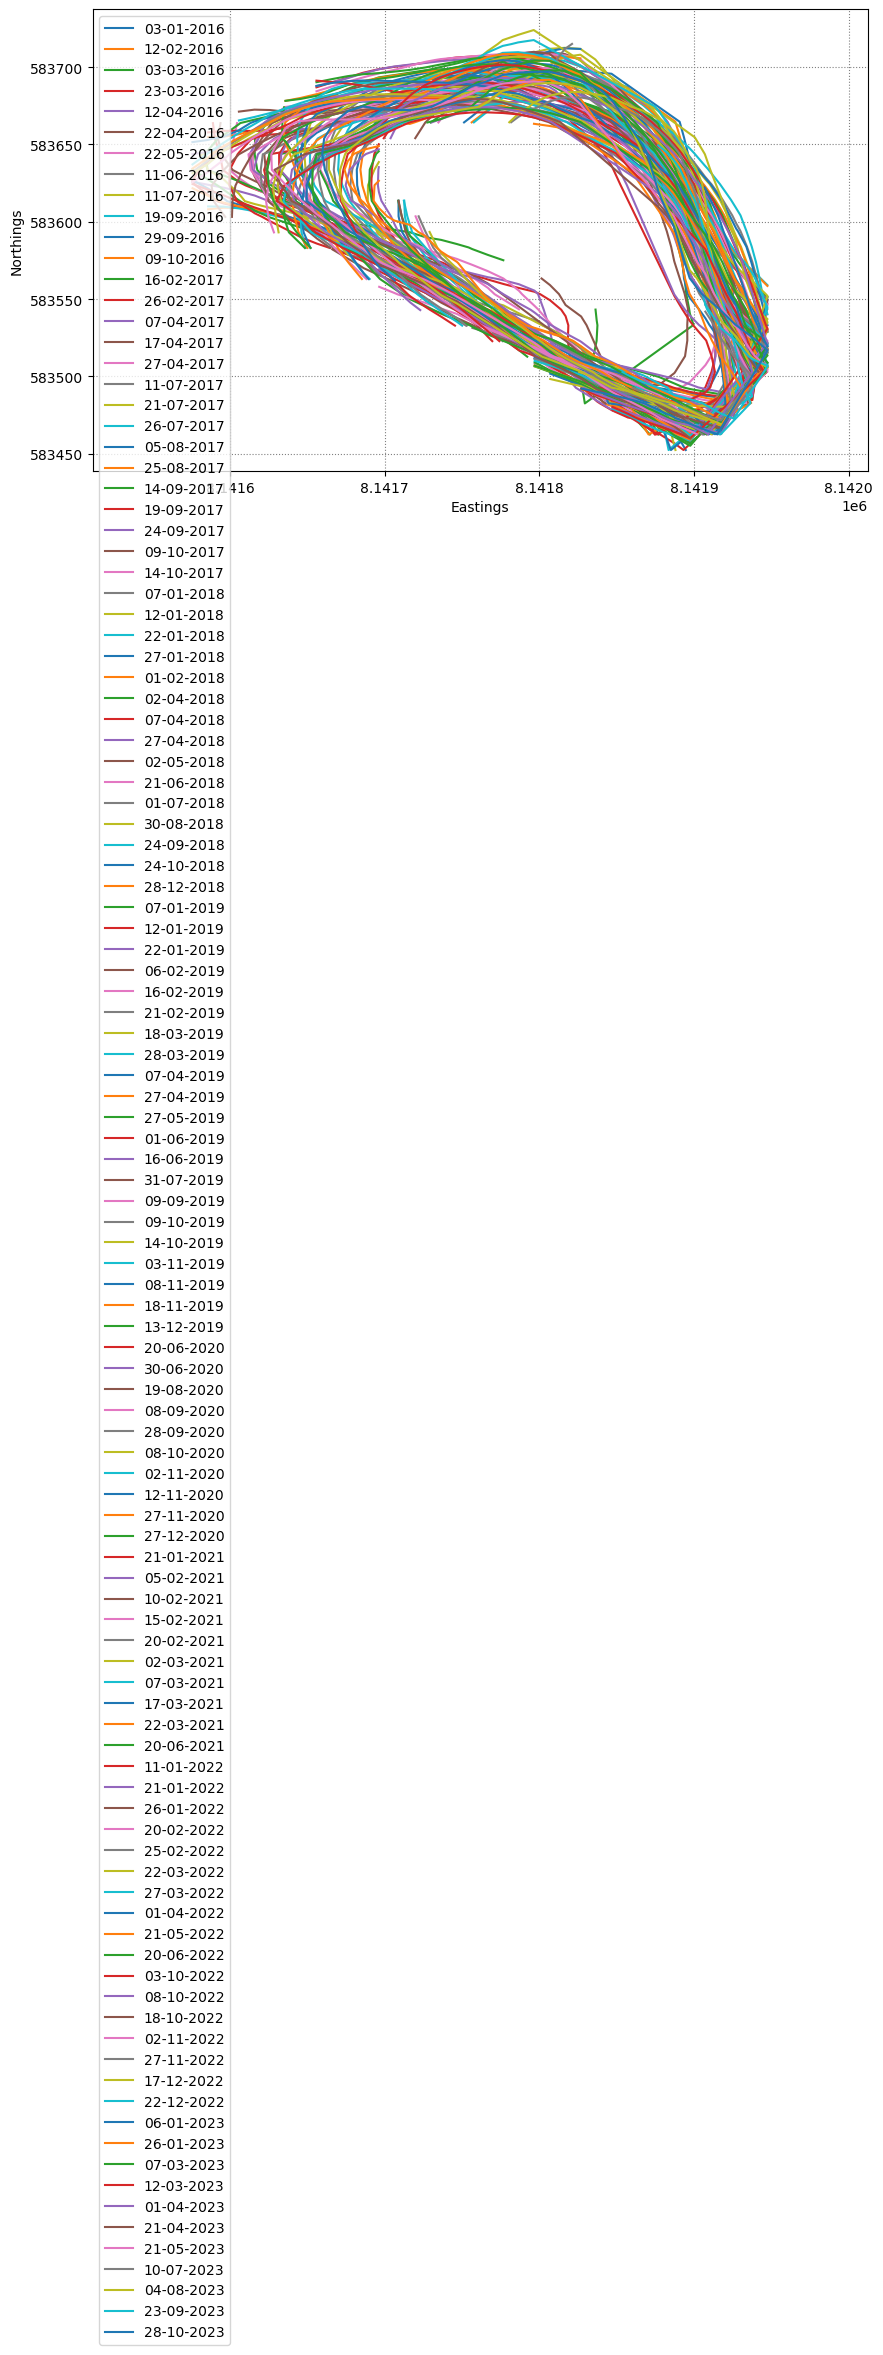

In [30]:
%matplotlib inline
# plot the sand polygons
fig = plt.figure(figsize=(10,6))
plt.axis('equal')
plt.xlabel('Eastings')
plt.ylabel('Northings')
plt.grid(linestyle=':', color='0.5')
for i in range(len(output['shorelines'])):
    sl = output['shorelines'][i]
    if len(sl)==0:
        continue
    np.append(sl, sl[0])
    date = output['dates'][i]
    plt.plot(sl[:,0], sl[:,1], '-', label=date.strftime('%d-%m-%Y'))
plt.legend()   

**Option 2**: Draw transects manually (if island is not circular)

Now, intersect the transects with the 2D contours to obtain time-series of cross-shore distance.

The time-series of shoreline change for each transect are saved in a .csv file in the data folder (all dates are in UTC time). 

### 4. Tidal correction

In [34]:
#load input tide data, it is in local time (Australian West Coast, UTC +8 hrs), but code below converts to UTC
tide_file = os.path.join(os.getcwd(),'example','EvaTide_2019.txt')
tide, output_corrected = SDS_islands.process_tide_data(tide_file, output)    

# define beach slope to be used for tidal correction
settings['beach_slope'] = 0.1375
# define reference height datum for tidal correction
settings['zref'] = 0      
# tidally correct the time-series of shoreline change along the transects              
cross_distance_corrected = SDS_islands.tide_correct(cross_distance,tide, output, transects, settings)
   
# also a function to tidally corrected the sand polygons     
output_corrected = SDS_islands.tide_correct_sand_polygon(cross_distance_corrected, output_corrected, settings)

Calculating tides: 39%

ValueError: min() arg is an empty sequence